# **Abstract**

This project explores the development and evaluation of a systematic trading strategy that integrates mean-reversion, momentum confirmation, and macroeconomic overlays to dynamically adjust equity market exposure. The strategy focuses on the SPY ETF, employing a BIAS measure to detect price deviations from a 42-day moving average and a VIX-adjusted Z-Score to normalize these deviations against prevailing volatility conditions. Momentum signals, calculated over a 12-month lookback period excluding the most recent month, provide trend confirmation to filter buy and sell signals. Position scaling is implemented to leverage exposure during favorable conditions (undervalued and positive momentum) and reduce exposure during unfavorable conditions (overvalued and weakening momentum). Additionally, a recession overlay integrates external macroeconomic signals, prompting the strategy to reduce SPY exposure to zero and allocate 15% to volatility-linked instruments during periods of heightened recession risk.

Empirical results demonstrate the strategy’s ability to improve risk-adjusted returns compared to a buy-and-hold approach. Over the analysis period (2007–2024), the strategy achieves a higher Sharpe Ratio (0.81 vs. 0.57), reduced maximum drawdowns (-41.66% vs. -70.00%), and improved downside protection as measured by the Sortino Ratio (1.00 vs. 0.70). These improvements reflect the strategy's dynamic positioning in response to market conditions and its recession overlay’s ability to mitigate losses during economic downturns. Robustness checks, including sensitivity to parameter adjustments, underscore the strategy’s dependence on stable market patterns and the reliability of external recession signals.

# **Sample Strategy**

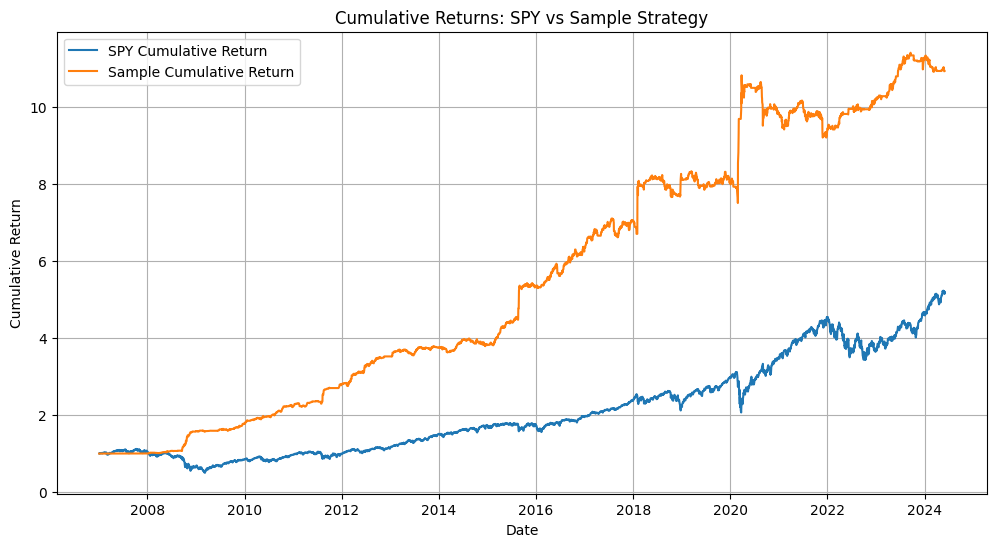

,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown(%),Skewness
Cumulative_SPY_ret,0.121368,0.199560,0.608177,-55.189448,-0.071015
Cumulative_sample_ret,0.152510,0.095536,1.596371,-14.939505,10.740877


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore')

data = pd.read_excel('project.volatility.data.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

def compute_z_score(data, column, window=30):
    """
    Compute the z-score for a given column using a rolling window.
    Args:
        data (pd.DataFrame): Dataframe containing the input data.
        column (str): Column name for which z-score is calculated.
        window (int): Lookback period for the rolling window.
    Returns:
        pd.DataFrame: Dataframe with additional z-score column.
    """
    data[f'{column}_mean'] = data[column].rolling(window=window).mean()
    data[f'{column}_std'] = data[column].rolling(window=window).std()
    data[f'{column}_zscore'] = (data[column] - data[f'{column}_mean']) / data[f'{column}_std']
    return data

def generate_signals(data, zscore_column, long_threshold=-2.5, short_threshold=2.5, close_threshold=2):
    data['longs'] = (data[zscore_column] <= long_threshold) * 1.0
    data['shorts'] = (data[zscore_column] >= short_threshold) * 1.0
    data['exits'] = (np.abs(data[zscore_column]) <= close_threshold) * 1.0

    # Initialize long_market and short_market tracking columns
    data['long_market'] = 0.0
    data['short_market'] = 0.0

    # Variables to track whether we are in a long or short market position
    long_market = 0
    short_market = 0

    # Iterate through the rows of the DataFrame
    for i, row in data.iterrows():
        # Enter long position if z-score is below the negative threshold
        if row['longs'] == 1.0:
            long_market = 1
            short_market = 0  # Ensure no conflicting positions

        # Enter short position if z-score is above the positive threshold
        if row['shorts'] == 1.0:
            short_market = 1
            long_market = 0  # Ensure no conflicting positions

        # Exit positions if z-score is within the exit threshold
        if row['exits'] == 1.0:
            long_market = 0
            short_market = 0

        # Assign market positions for the current row
        data.at[i, 'long_market'] = long_market
        data.at[i, 'short_market'] = short_market

        if row[zscore_column] < close_threshold:
            data.at[i, 'short_market'] = 0
        elif row[zscore_column] > -close_threshold:
            data.at[i, 'long_market'] = 0
    return data

def calculate_returns(data, asset1_ret='SPY_ret', asset2_ret='f30w_ret'):
    """
    Calculate strategy returns and cumulative returns based on separate long and short market positions.
    Args:
        data (pd.DataFrame): Dataframe containing signals and return columns.
        long_market_column (str): Column indicating if the strategy is in a long position.
        short_market_column (str): Column indicating if the strategy is in a short position.
        asset_return_column (str): Column with returns of the main asset (e.g., f30w_ret).
        spy_return_column (str): Column with returns of SPY.
    Returns:
        pd.DataFrame: Dataframe with strategy and cumulative returns.
    """
    # Shift returns upward to align with previous day's positions
    data[f'{asset1_ret}_shifted'] = data[asset1_ret].shift(-1)
    data[f'{asset2_ret}_shifted'] = data[asset2_ret].shift(-1)

    data['positions'] = data['long_market'] - data['short_market']
    data['port_f30_ret'] = data['positions'] * -data[f'{asset2_ret}_shifted']
    data['port_spy_ret'] = data['positions'] * data[f'{asset1_ret}_shifted']  # Shorting earns opposite returns

    # Sum returns to calculate total strategy returns
    data['strategy_total_ret'] = (
        0.5*data['port_f30_ret'] + 0.5*data['port_spy_ret']
    )

    # Calculate cumulative returns
    data['cumulative_strategy_ret'] = (1 + data['strategy_total_ret']).cumprod()
    return data

df = data[['SPY','VIX','VVIX','f30','f30w_ret']]
df['SPY_ret'] = df['SPY'].pct_change()
column = 'VVIX'
zscore_column = f'{column}_zscore'

z_score = compute_z_score(df, column, window=30)
signals = generate_signals(z_score, zscore_column)
portfolio = calculate_returns(signals)

sample = pd.read_excel('project.volatility.data.xlsx', sheet_name="project.sampleStrategy")
sample = sample.drop(columns=["Unnamed: 8", "Unnamed: 9"])
sample['SPY_alloc'] = sample['SPY_alloc'].fillna(0)
sample['f30_alloc'] = sample['f30_alloc'].fillna(0)

def sample_ret(sample):
    sample["SPY_ret_shifted"] = sample["SPY_ret"].shift(-1)
    sample["f30_ret_shifted"] = sample["f30w_ret"].shift(-1)

    # Calculate the sample return
    sample["sample_ret"] = (
        (sample["SPY_ret_shifted"] * sample["SPY_alloc"]) +
        (sample["f30_ret_shifted"] * sample["f30_alloc"])
    )

    return sample

sample = sample_ret(sample)
sample['Cumulative_SPY_ret'] = (1 + sample['SPY_ret']).cumprod()
sample['Cumulative_sample_ret'] = (1 + sample['sample_ret']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(sample['Date'], sample['Cumulative_SPY_ret'], label='SPY Cumulative Return')
plt.plot(sample['Date'], sample['Cumulative_sample_ret'], label='Sample Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns: SPY vs Sample Strategy')
plt.legend()
plt.grid()
plt.show()

def calculate_performance_metrics(cumulative_asset_returns, annualization_factor=252, rf=0):

    # Calculate returns (percentage change)
    returns_assets = cumulative_asset_returns.pct_change()

    def calculate_drawdown(cumulative_returns):
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min() * 100  # Convert to percentage

    # Calculate metrics
    def calculate_metrics(returns):
        annual_return = (1 + returns.mean()) ** annualization_factor - 1
        annual_volatility = returns.std() * np.sqrt(annualization_factor)
        drawdowns = calculate_drawdown((1 + returns).cumprod())
        skewness = returns.skew()
        sharpe_ratio = (annual_return - rf) / annual_volatility
        return annual_return, annual_volatility, sharpe_ratio, drawdowns, skewness

    metrics = {}

    # Metrics for individual assets
    for asset in returns_assets.columns:
        metrics[asset] = calculate_metrics(returns_assets[asset])

    # Convert metrics to DataFrame
    metrics_df = pd.DataFrame.from_dict(
        metrics, orient="index", columns=["Annual Return", "Annual Volatility", "Sharpe Ratio","Max Drawdown(%)", "Skewness"]
    )

    return metrics_df

cumulative_asset_returns = sample[['Cumulative_SPY_ret','Cumulative_sample_ret']]
cumulative_asset_returns.dropna()

metrics_sample = calculate_performance_metrics(cumulative_asset_returns)
metrics_sample

# **Why is the sample strategy interesting?**

This strategy is interesting because it demonstrates a meaningful improvement in performance when compared to a traditional benchmark like the SPY. Over the observed period, the cumulative return line of the sample strategy consistently outpaces that of SPY, indicating that it not only grows capital at a faster rate but also sustains that growth through multiple market cycles. The difference in the shape and trajectory of the cumulative returns is visually striking; where SPY shows a steady but modest rise, the sample strategy’s line ascends more rapidly and maintains higher levels, suggesting that it may be capturing opportunities beyond what passive market exposure can deliver.

Equally important, the strategy does not merely chase higher returns by taking on outsized risk. A closer look at its underlying volatility and drawdowns reveals that it experiences significantly less severe declines than SPY, and it maintains a smoother path along its growth curve. This lower volatility means that investors face fewer emotionally challenging drawdowns, which can be critical in ensuring long-term adherence to the strategy. In other words, it not only makes money at a better rate, but does so with a steadier hand, potentially making it easier to hold during turbulent periods.

What stands out most is the improvement in the risk-adjusted metrics, such as the Sharpe ratio. By delivering more return per unit of risk and keeping drawdowns in check, the strategy suggests a more efficient way to generate returns. Instead of exposing the investor to wild swings and painful losses, it appears to mitigate these risks, possibly through dynamic positioning or some form of hedging. Such positive skewness in returns further indicates that the strategy’s gains are not simply a matter of luck or a single opportunistic trade, but rather the outcome of a systematic approach that tilts the odds in favor of producing persistent, positive returns.

# **Our Strategy** (For detailed strategy construction, please see strategy.pdf)

## **Rationale and Strategy Construction**

**The strategy presented here seeks to combine elements of mean-reversion, volatility-adjusted valuation, momentum confirmation, and a recession overlay into a single systematic trading approach.** Conceptually, the method begins by measuring the distance of the SPY (S&P 500 ETF) price from its short-term moving average, computing a BIAS measure to detect when the market is relatively cheap or expensive. For example, a 42-day moving average (short_window = 42) is used, and the BIAS, expressed as a percentage, indicates how far the current price deviates from the average. A BIAS of +10% would mean the price is 10% above its 42-day average, while a BIAS of -5% would mean it is 5% below. To give more context to this deviation, the strategy calculates the Z-Score of the BIAS by standardizing it with the VIX. This step ensures that not only the deviation from the mean is considered, but also the prevailing volatility regime, so that what might be a large and alarming deviation in a low-volatility environment would be less remarkable in a high-volatility environment. In this strategy, a Z-Score threshold of -0.2 indicates that the market is sufficiently “cheap” relative to its recent trend and volatility to warrant a more aggressive buying posture, while a threshold of +0.2 suggests the market is relatively “expensive” and justifies reducing exposure.

**In conjunction with the mean-reversion and volatility signals, the strategy also employs a momentum factor.** The momentum calculation involves looking back at a 12-month period and ignoring the most recent 21 trading days (approximately one month) to mitigate short-term noise. The result is a momentum measure that captures the medium-term trend of the market. By also computing and utilizing a 60-day moving average of this momentum measure, the strategy can confirm whether recent performance aligns with longer-term trends. For instance, if the raw momentum reading stands at 0.10 (indicating about a 10% gain over the lookback period excluding the last month) and the 60-day momentum average is 0.05, then the momentum is not only positive but substantially above its smoother trend line. In combination with a strongly negative Z-Score (e.g., less than -0.2), this suggests the market is both undervalued and supported by upward momentum, prompting the strategy to leverage up to a position size of 3 times normal for the subsequent 21 trading days.

Conversely, when the Z-Score rises above +0.2, indicating the market is expensive relative to its average, and momentum falls below its moving average minus 0.05, the strategy interprets this as a dangerous environment. This situation might occur, for example, if the BIAS Z-Score is 0.25 and the momentum reading of -0.10 is well below its 60-day average of -0.05 minus another 0.05 threshold, confirming that both the valuation metric and the trend are unfavorable. Under such conditions, the strategy scales down exposure to a mere 0.25 of normal for the next 21 trading days, thereby reducing the risk of holding an overpriced and weakening market.

**In addition to these signals, a recession overlay is introduced to further refine the approach.** The strategy employs externally sourced recession signals, which may be derived from macroeconomic indicators or proprietary models, and identifies periods flagged as recessionary. When the signal indicates an active recession, the strategy takes immediate action by reducing the SPY position to zero and allocating 0.15 to a VIX-related instrument (such as an ETF or futures linked to volatility). This allocation persists for 42 trading days following the start of a recession signal. For instance, if the recession signal triggered on January 15, and the next available trading day in the data is January 16, the SPY position is set to zero and the VIX position to 0.15 until approximately mid-to-late February, depending on the exact window length. The rationale is that in recessions, the market’s historical patterns of mean-reversion and momentum may not hold as reliably, and shifting some exposure to volatility instruments can provide diversification and partial downside protection.

## **Code Implementation**

The code implementing this strategy follows a logical sequence. It **begins by loading price and volatility data from an Excel file** and converting dates to a suitable format. It then calculates the 42-day moving average, the BIAS, and subsequently the VIX-adjusted Z-Score of the BIAS over a 300-day window. Following that, it **computes momentum over a 12-month lookback period** (approximately 252 trading days), skipping the most recent 21 days, and then takes a 60-day moving average of this momentum. The buy and sell conditions are clearly defined as logical thresholds on the Z-Score and momentum readings. Once those conditions are met, the position sizing rules are straightforward: **increase position to 3x on buy signals for 21 days, reduce to 0.25x on sell signals for 21 days, and override to 0 SPY and 0.15 VIX allocation for 42 days during recessionary periods.** The code shifts the position signals by one day to avoid lookahead bias and calculates daily returns, cumulative returns, and a suite of performance metrics for evaluation.

## **Recession Signal**

We transform the combined dataset into monthly intervals and compute monthly returns. We incorporate measures like the VIX and inflation-linked variables, enabling us to assess correlations between NASDAQ returns and an inflation metric across different historical periods. Through both static and rolling correlations, we visualize shifting relationships and mark recession periods for economic context. Additionally, we highlight moments when correlations are high but equity prices decline, offering a richer understanding of how market behavior intertwines with economic conditions over time.

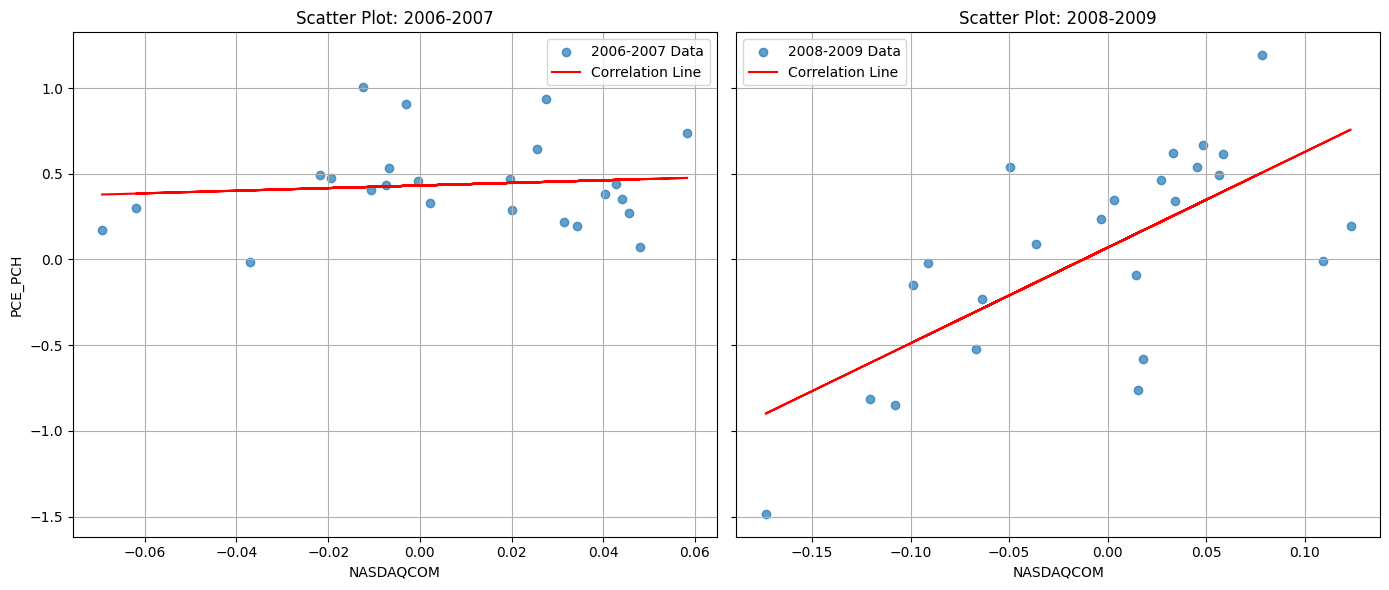

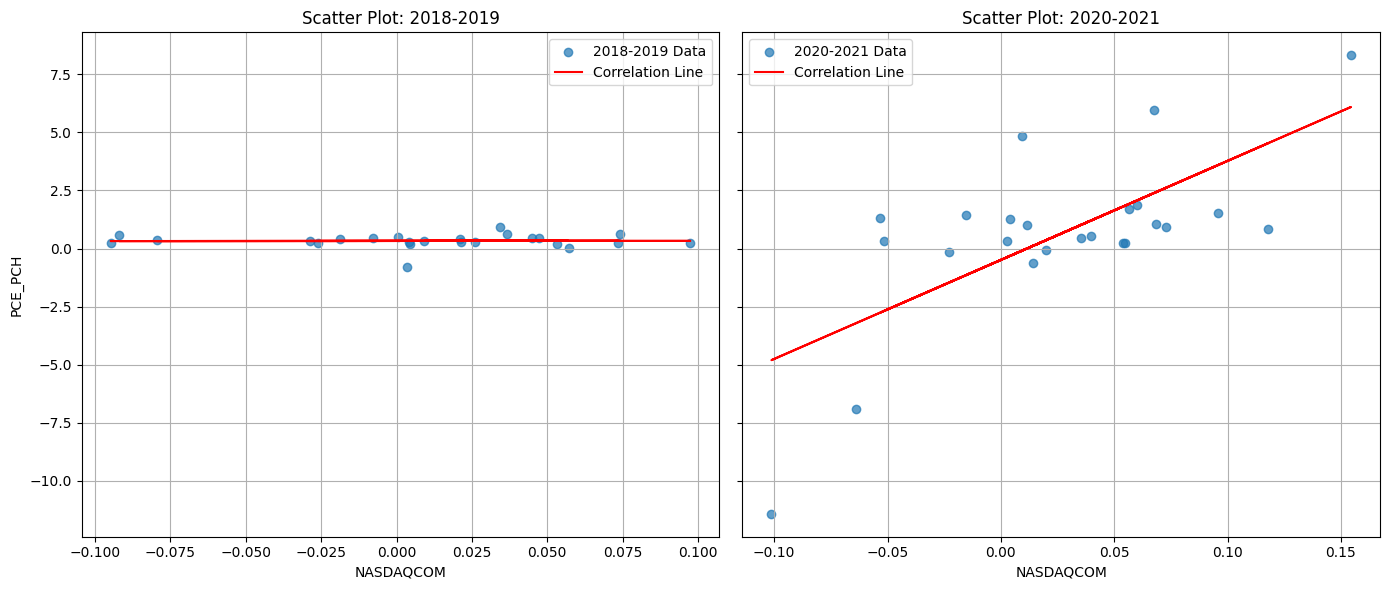

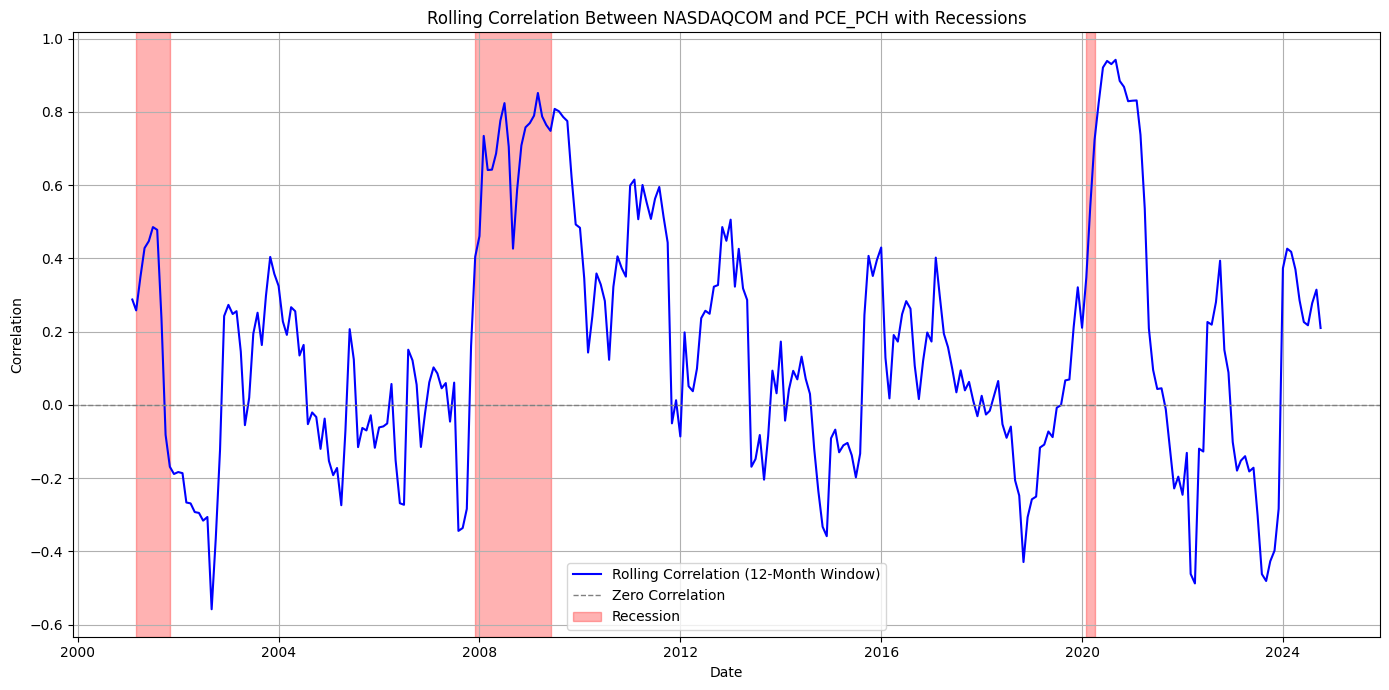

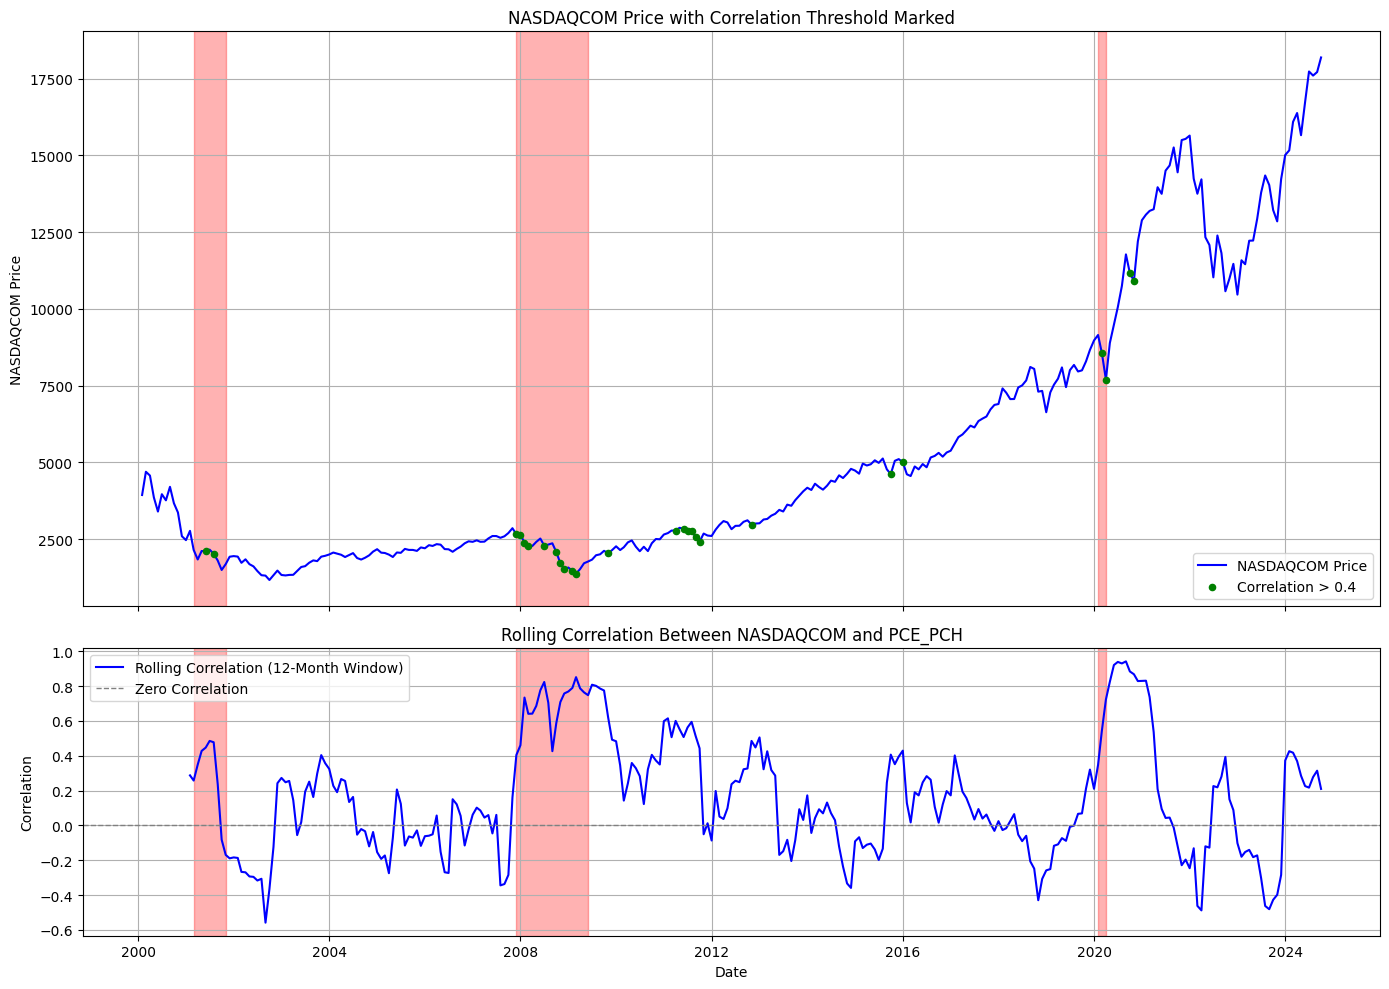

In [9]:
# Load the main dataset
fred_raw = pd.read_excel('fredgraph.xls')

# Convert observation_date to a datetime format
fred_raw["observation_date"] = pd.to_datetime(fred_raw["observation_date"])

# Set the observation_date as the index
fred_raw.set_index("observation_date", inplace=True)

# Resample SP500 and NASDAQCOM to monthly frequency, keeping the last value of each month
fred_monthly = fred_raw[['SP500', 'NASDAQCOM']].resample('M').last()

# Calculate percentage change for SP500 and NASDAQCOM (monthly returns)
fred_monthly_returns = fred_monthly.pct_change()

# Resample VIX data to match the monthly frequency, taking the last value for each month
vix_monthly = fred_raw[['VIXCLS']].resample('M').last()
fred_monthly_returns['VIX'] = vix_monthly['VIXCLS']

nasdaq_prices = fred_raw[['NASDAQCOM']].resample('M').last()  # Resample to monthly and get last price
fred_monthly_returns['NASDAQ_Price'] = nasdaq_prices['NASDAQCOM'].values

# Reset index for better presentation
fred_monthly_returns.reset_index(inplace=True)

fred_monthly_returns['observation_date'] = fred_monthly_returns['observation_date'] + pd.offsets.MonthBegin(0)

# Load CPI data
cpi = pd.read_excel('CPI.xlsx')
cpi["observation_date"] = pd.to_datetime(cpi["observation_date"])

# Merge the two DataFrames on observation_date
combined_df = pd.merge(fred_monthly_returns, cpi, on="observation_date")

# Select data for specific periods
subset_2006_2007 = combined_df[(combined_df["observation_date"] >= "2006-01-01") & (combined_df["observation_date"] <= "2007-12-31")]
subset_2008_2009 = combined_df[(combined_df["observation_date"] >= "2008-01-01") & (combined_df["observation_date"] <= "2009-12-31")]

# Calculate correlations for each period
correlation_2006_2007 = subset_2006_2007[["NASDAQCOM", "PCE_PCH"]].corr().iloc[0, 1]
correlation_2008_2009 = subset_2008_2009[["NASDAQCOM", "PCE_PCH"]].corr().iloc[0, 1]

# Prepare the result
correlation_changes = pd.DataFrame({
    "Period": ["2006-2007", "2008-2009"],
    "NASDAQ vs PCE_PCH Correlation": [correlation_2006_2007, correlation_2008_2009]
})

# Prepare scatter plot data for the two periods
scatter_data = {
    "2006-2007": subset_2006_2007[["NASDAQCOM", "PCE_PCH"]].dropna(),
    "2008-2009": subset_2008_2009[["NASDAQCOM", "PCE_PCH"]].dropna(),
}

# Plot scatter plots with correlation lines
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, period in enumerate(scatter_data.keys()):
    data = scatter_data[period]
    ax[i].scatter(data["NASDAQCOM"], data["PCE_PCH"], alpha=0.7, label=f"{period} Data")

    # Add a trendline (linear fit)
    z = np.polyfit(data["NASDAQCOM"], data["PCE_PCH"], 1)
    p = np.poly1d(z)
    ax[i].plot(data["NASDAQCOM"], p(data["NASDAQCOM"]), color="red", label="Correlation Line")

    ax[i].set_title(f"Scatter Plot: {period}")
    ax[i].set_xlabel("NASDAQCOM")
    ax[i].set_ylabel("PCE_PCH" if i == 0 else "")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Select data for additional specific periods
subset_2018_2019 = combined_df[(combined_df["observation_date"] >= "2018-01-01") & (combined_df["observation_date"] <= "2019-12-31")]
subset_2020_2021 = combined_df[(combined_df["observation_date"] >= "2020-01-01") & (combined_df["observation_date"] <= "2021-12-31")]

# Calculate correlations for each new period
correlation_2018_2019 = subset_2018_2019[["NASDAQCOM", "PCE_PCH"]].corr().iloc[0, 1]
correlation_2020_2021 = subset_2020_2021[["NASDAQCOM", "PCE_PCH"]].corr().iloc[0, 1]

# Update the result DataFrame
correlation_changes = pd.DataFrame({
    "Period": ["2018-2019", "2020-2021"],
    "NASDAQ vs PCE_PCH Correlation": [
        correlation_2018_2019,
        correlation_2020_2021
    ]
})

# Prepare scatter plot data for the new periods
scatter_data_new = {
    "2018-2019": subset_2018_2019[["NASDAQCOM", "PCE_PCH"]].dropna(),
    "2020-2021": subset_2020_2021[["NASDAQCOM", "PCE_PCH"]].dropna(),
}

# Plot scatter plots with correlation lines for the new periods
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, period in enumerate(scatter_data_new.keys()):
    data = scatter_data_new[period]
    ax[i].scatter(data["NASDAQCOM"], data["PCE_PCH"], alpha=0.7, label=f"{period} Data")

    # Add a trendline (linear fit)
    z = np.polyfit(data["NASDAQCOM"], data["PCE_PCH"], 1)
    p = np.poly1d(z)
    ax[i].plot(data["NASDAQCOM"], p(data["NASDAQCOM"]), color="red", label="Correlation Line")

    ax[i].set_title(f"Scatter Plot: {period}")
    ax[i].set_xlabel("NASDAQCOM")
    ax[i].set_ylabel("PCE_PCH" if i == 0 else "")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Define the rolling window size (e.g., 12 months for a 1-year window)
rolling_window = 12

# Calculate rolling correlations between NASDAQCOM and PCE_PCH
combined_df['Rolling_Correlation'] = combined_df['NASDAQCOM'].rolling(window=rolling_window).corr(combined_df['PCE_PCH'])

# Define recession periods (example: start and end dates for recessions)
recessions = [
    ("2001-03-01", "2001-11-01"),
    ("2007-12-01", "2009-06-01"),
    ("2020-02-01", "2020-04-01"),
]

# Convert recession periods to datetime for plotting
recession_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in recessions]

# Plot the rolling correlation with recession shading
plt.figure(figsize=(14, 7))
plt.plot(combined_df['observation_date'], combined_df['Rolling_Correlation'], label=f'Rolling Correlation ({rolling_window}-Month Window)', color='blue')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Correlation')

# Add shaded areas for recessions
for start, end in recession_periods:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")

plt.title('Rolling Correlation Between NASDAQCOM and PCE_PCH with Recessions')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a figure with two subplots: NASDAQ price and correlation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot NASDAQCOM prices on the top subplot
ax1.plot(combined_df['observation_date'], combined_df['NASDAQ_Price'], label='NASDAQCOM Price', color='blue')
ax1.set_title('NASDAQCOM Price with Correlation Threshold Marked')
ax1.set_ylabel('NASDAQCOM Price')
ax1.grid(True)
ax1.legend()

# Highlight periods where Rolling_Correlation > 0.4 and price is declining
threshold = 0.4
highlight = combined_df[(combined_df['Rolling_Correlation'] > threshold) & (combined_df['NASDAQ_Price'].diff() < 0)]
ax1.scatter(highlight['observation_date'], highlight['NASDAQ_Price'], color='green', label=f'Correlation > {threshold}', zorder=5, s=20)
ax1.legend()

# Plot Rolling Correlation on the bottom subplot
ax2.plot(combined_df['observation_date'], combined_df['Rolling_Correlation'], label=f'Rolling Correlation ({rolling_window}-Month Window)', color='blue')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Correlation')
ax2.set_title('Rolling Correlation Between NASDAQCOM and PCE_PCH')
ax2.set_xlabel('Date')
ax2.set_ylabel('Correlation')
ax2.legend()
ax2.grid(True)

# Add recession shading on both subplots
for start, end in recession_periods:
    ax1.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")
    ax2.axvspan(start, end, color='red', alpha=0.3, label='Recession' if start == pd.to_datetime(recessions[0][0]) else "")

plt.tight_layout()
plt.show()


# **Strategy Construction**

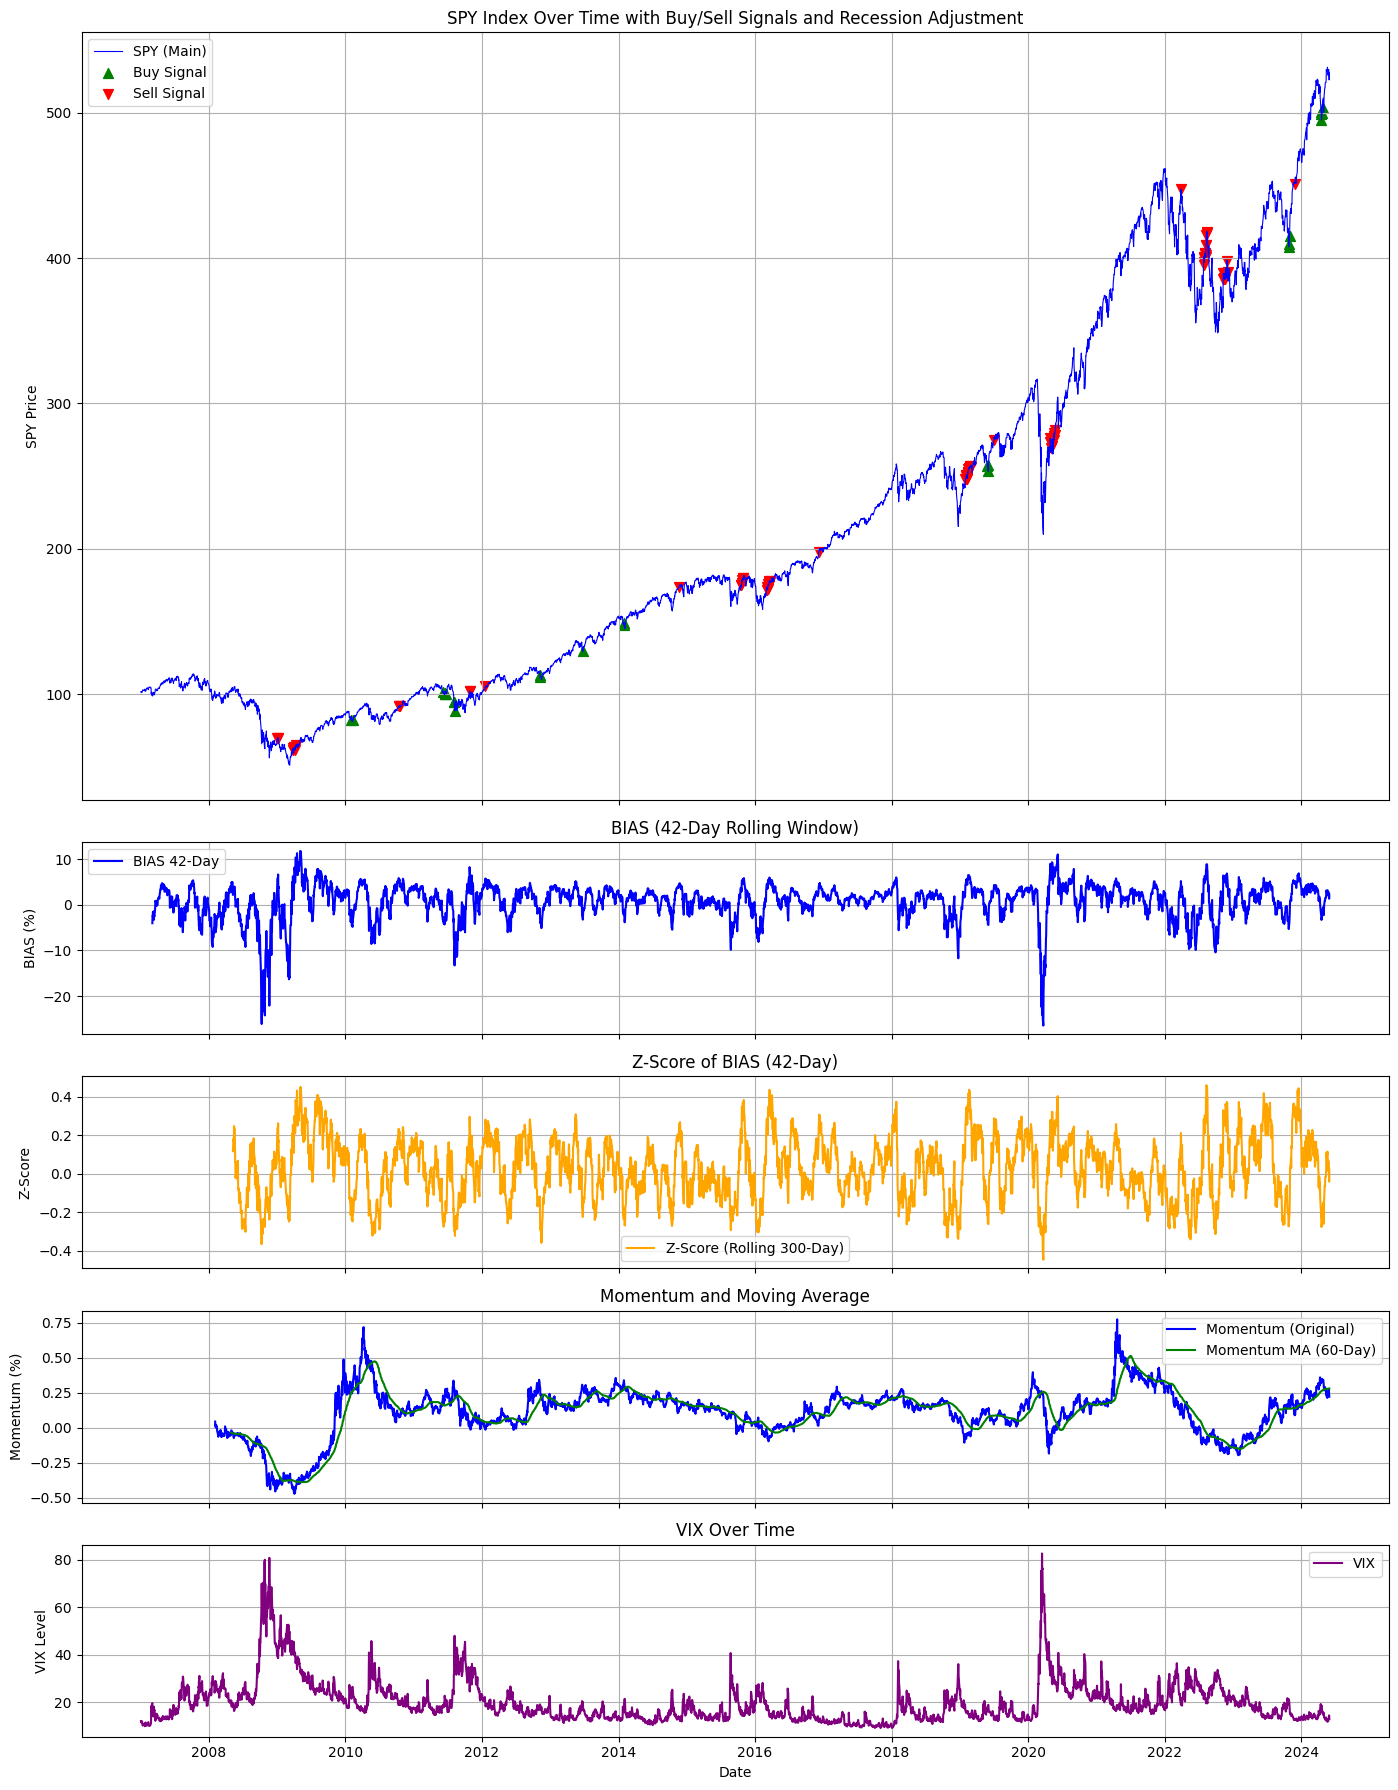

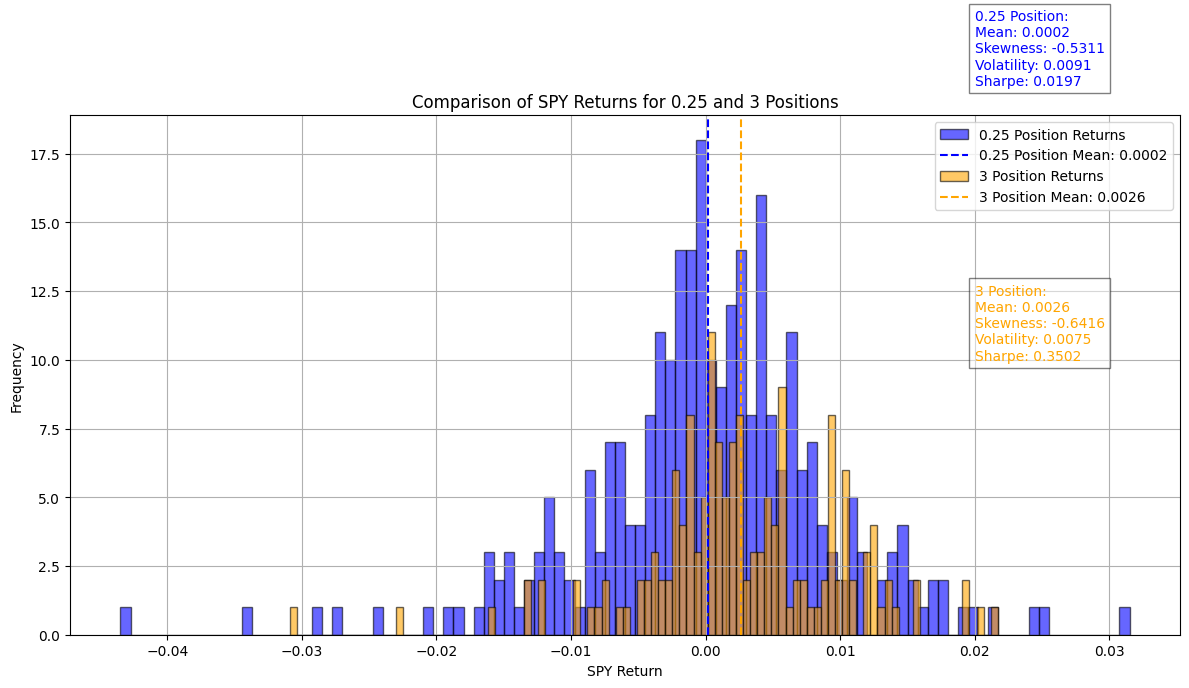

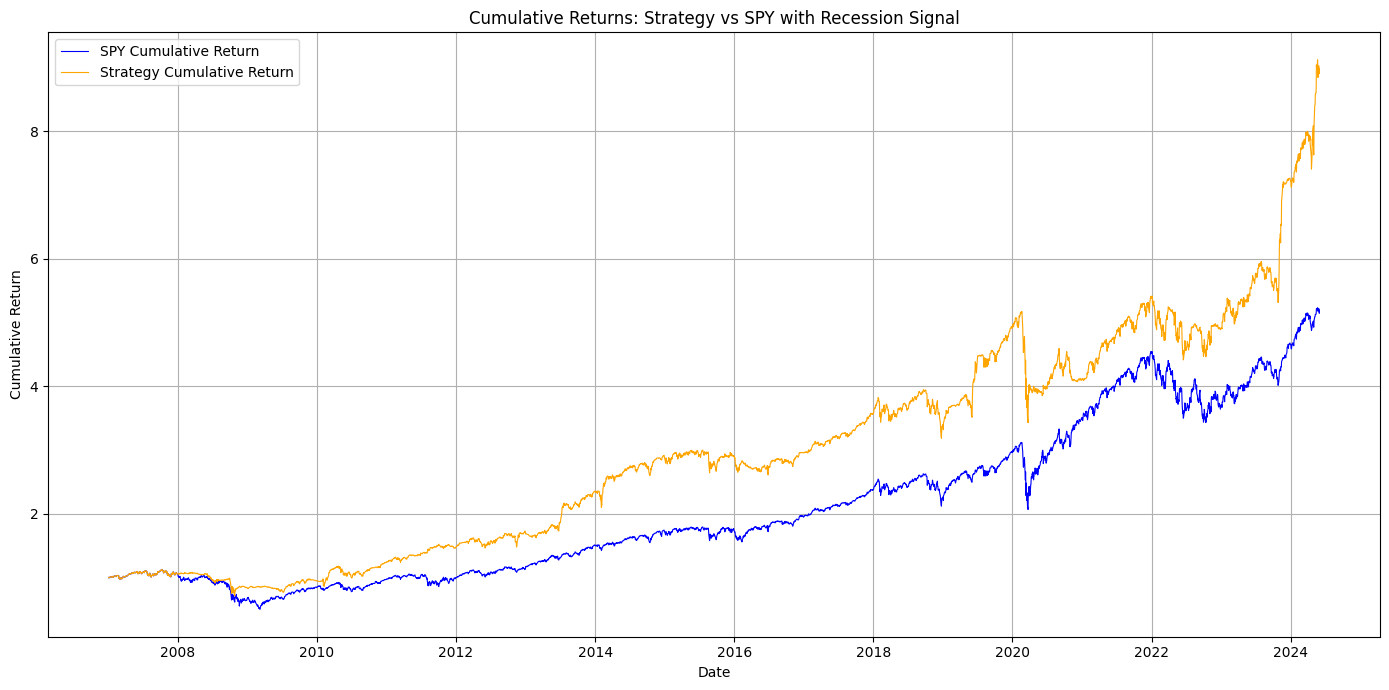

          Mean Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown  \
SPY          0.000455     0.01257      0.574685       0.700644     -0.700044   
Strategy     0.000561     0.01099      0.810980       1.000599     -0.416643   

          Skewness  
SPY      -0.071113  
Strategy  0.247915  


In [11]:
df = pd.read_excel('project.volatility.data.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# ========== Define Functions from Previous Strategy ==========
def calculate_bias(data, column, short_window):
    """
    Calculate BIAS (Deviation Rate).
    """
    ma_col = f"MA_{short_window}"
    bias_col = f"BIAS_{short_window}"
    data[ma_col] = data[column].rolling(window=short_window).mean()
    data[bias_col] = (data[column] - data[ma_col]) / data[ma_col] * 100
    return data

def calculate_bias_zscore(data, bias_col, z_window):
    """
    Calculate the z-score of BIAS over a rolling window, scaled by VIX.
    """
    z_col = f"Z_Score_{bias_col}_{z_window}"
    data[z_col] = (data[bias_col] - data[bias_col].rolling(window=z_window).mean()) / data['VIX']
    return data

def calculate_momentum(data, column, lookback_months, skip_days):
    """
    Calculate Momentum as the percentage return over a lookback period.
    """
    lookback_days = lookback_months * 21  # Approximate trading days in a month
    data['Momentum'] = data[column].shift(skip_days) / data[column].shift(lookback_days + skip_days) - 1
    return data

# ========== Parameters for Original Signals ==========
short_window = 42  # For BIAS
z_window = 300      # For BIAS Z-Score
momentum_lookback_months = 12
momentum_skip_days = 21

# ========== Apply Calculations ==========
df = calculate_bias(df, 'SPY', short_window)
df = calculate_bias_zscore(df, f"BIAS_{short_window}",  z_window)
df = calculate_momentum(df, 'SPY', momentum_lookback_months, momentum_skip_days)

# Add Momentum Moving Average
momentum_window = 60
momentum_ma_col = f"MA_Momentum_{momentum_window}"
df[momentum_ma_col] = df["Momentum"].rolling(window=momentum_window).mean()

# Define start and end dates for filtering
start_date = "2007-01-01"
end_date = "2024-12-31"
df_filtered = df[(df.index >= start_date) & (df.index <= end_date)].copy()

# ========== Original Buy/Sell Conditions ==========
bias_col = f"BIAS_{short_window}"
z_score_col = f"Z_Score_{bias_col}_{z_window}"

buy_condition = (df_filtered[z_score_col] < -0.2) & (df_filtered["Momentum"] > df_filtered[momentum_ma_col] + 0.05)
sell_condition = (df_filtered[z_score_col] > 0.2) & (df_filtered["Momentum"] < df_filtered[momentum_ma_col] - 0.05)

# Initialize Positions
df_filtered["Position"] = 1

# Scale Positions on Buy/Sell Signals
df_indices = df_filtered.index
for idx in df_filtered[buy_condition].index:
    start_idx = df_indices.get_loc(idx)
    end_idx = min(start_idx + 21, len(df_filtered))
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 3

for idx in df_filtered[sell_condition].index:
    start_idx = df_indices.get_loc(idx)
    end_idx = min(start_idx + 21, len(df_filtered))
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 0.25

# Shift position by one day
df_filtered["Position"] = df_filtered["Position"].shift(1)

# Calculate SPY Daily Returns
df_filtered["SPY_Return"] = df_filtered["SPY"].pct_change()

# ========== Incorporate Recession Signals ==========
recession_signals = pd.read_excel('signal.xlsx')
recession_signals = recession_signals[recession_signals['observation_date'] > '2007-01-01'].copy()
recession_signals['observation_date'] = pd.to_datetime(recession_signals['observation_date'])

recession_signals["next_month_first_day"] = (
    recession_signals["observation_date"] + pd.offsets.MonthBegin(1)
).dt.normalize()

# Match next_month_first_day to the first available trading day in df_filtered
recession_signals["Date"] = recession_signals["next_month_first_day"].apply(
    lambda x: df_filtered[df_filtered.index >= x].index.min()
)

# Merge recession_signals into df_filtered
df_filtered = df_filtered.reset_index()
df_filtered = pd.merge(df_filtered,
                       recession_signals[["Date", "sig"]],
                       how="left",
                       on="Date")
df_filtered["sig"] = df_filtered["sig"].fillna(0)
df_filtered = df_filtered.set_index("Date")

# If there's a VIX-based instrument, ensure it exists
# Assuming 'f90w_ret' column exists in df_filtered for the VIX-based returns
if 'f90w_ret' not in df_filtered.columns:
    df_filtered['f90w_ret'] = 0  # Placeholder if not available

df_filtered['Position_VIX'] = 0

# For each recession signal, override position for 42 days
for signal_date in recession_signals.loc[recession_signals["sig"] == 1, "Date"]:
    start_idx = df_filtered.index.get_loc(signal_date)
    end_idx = min(start_idx + 42, len(df_filtered))
    # During recession signal periods: SPY pos = 0, VIX pos = 0.15
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position")] = 0
    df_filtered.iloc[start_idx:end_idx, df_filtered.columns.get_loc("Position_VIX")] = 0.15

# Recalculate Strategy Returns incorporating Recession Adjustments
df_filtered["Strategy_Return_recession"] = df_filtered["SPY_Return"] * df_filtered["Position"] \
                                           + df_filtered["f90w_ret"] * df_filtered["Position_VIX"]

df_filtered["SPY_Cumulative"] = (1 + df_filtered["SPY_Return"]).cumprod()
df_filtered["Strategy_Cumulative_recession"] = (1 + df_filtered["Strategy_Return_recession"]).cumprod()

# ========== Plotting as done before ==========
fig, axs = plt.subplots(5, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [4, 1, 1, 1, 1]}, sharex=True)

# Plot SPY with buy/sell signals
axs[0].plot(df_filtered.index, df_filtered["SPY"], label="SPY (Main)", color="blue", linewidth=0.8)
axs[0].scatter(df_filtered.index[buy_condition.reindex(df_filtered.index, fill_value=False)],
               df_filtered["SPY"][buy_condition.reindex(df_filtered.index, fill_value=False)],
               color="green", label="Buy Signal", marker="^", s=50)
axs[0].scatter(df_filtered.index[sell_condition.reindex(df_filtered.index, fill_value=False)],
               df_filtered["SPY"][sell_condition.reindex(df_filtered.index, fill_value=False)],
               color="red", label="Sell Signal", marker="v", s=50)
axs[0].set_title("SPY Index Over Time with Buy/Sell Signals and Recession Adjustment")
axs[0].set_ylabel("SPY Price")
axs[0].legend()
axs[0].grid(True)

# BIAS
axs[1].plot(df_filtered.index, df_filtered[bias_col], label=f"BIAS {short_window}-Day", color="blue")
axs[1].set_title(f"BIAS ({short_window}-Day Rolling Window)")
axs[1].set_ylabel("BIAS (%)")
axs[1].legend()
axs[1].grid(True)

# Z-Score of BIAS
axs[2].plot(df_filtered.index, df_filtered[z_score_col], label=f"Z-Score (Rolling {z_window}-Day)", color="orange")
axs[2].set_title(f"Z-Score of BIAS ({short_window}-Day)")
axs[2].set_ylabel("Z-Score")
axs[2].legend()
axs[2].grid(True)

# Momentum
axs[3].plot(df_filtered.index, df_filtered["Momentum"], label="Momentum (Original)", color="blue")
axs[3].plot(df_filtered.index, df_filtered[momentum_ma_col], label=f"Momentum MA ({momentum_window}-Day)", color="green")
axs[3].set_title("Momentum and Moving Average")
axs[3].set_ylabel("Momentum (%)")
axs[3].legend()
axs[3].grid(True)

# VIX (Just plotting VIX since we referenced it; adjust as needed)
axs[4].plot(df_filtered.index, df_filtered['VIX'], label="VIX", color="purple")
axs[4].set_title("VIX Over Time")
axs[4].set_xlabel("Date")
axs[4].set_ylabel("VIX Level")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout()
plt.show()

# ========== Histograms and Statistics for Different Positions ==========
returns_025 = df_filtered[df_filtered["Position"] == 0.25]["SPY_Return"]
returns_3 = df_filtered[df_filtered["Position"] == 3]["SPY_Return"]

mean_025 = returns_025.mean()
skewness_025 = returns_025.skew()
vol_025 = returns_025.std()
sharpe_ratio_025 = mean_025 / vol_025 if vol_025 != 0 else float('nan')

mean_3 = returns_3.mean()
skewness_3 = returns_3.skew()
vol_3 = returns_3.std()
sharpe_ratio_3 = mean_3 / vol_3 if vol_3 != 0 else float('nan')

plt.figure(figsize=(12, 7))
plt.hist(returns_025.dropna(), bins=100, alpha=0.6, color="blue", label="0.25 Position Returns", edgecolor="black")
plt.axvline(mean_025, color="blue", linestyle="--", label=f"0.25 Position Mean: {mean_025:.4f}")
plt.hist(returns_3.dropna(), bins=100, alpha=0.6, color="orange", label="3 Position Returns", edgecolor="black")
plt.axvline(mean_3, color="orange", linestyle="--", label=f"3 Position Mean: {mean_3:.4f}")

plt.text(0.02, 20, f"0.25 Position:\nMean: {mean_025:.4f}\nSkewness: {skewness_025:.4f}\nVolatility: {vol_025:.4f}\nSharpe: {sharpe_ratio_025:.4f}",
         color="blue", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.02, 10, f"3 Position:\nMean: {mean_3:.4f}\nSkewness: {skewness_3:.4f}\nVolatility: {vol_3:.4f}\nSharpe: {sharpe_ratio_3:.4f}",
         color="orange", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Comparison of SPY Returns for 0.25 and 3 Positions")
plt.xlabel("SPY Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Cumulative Return Plot with Recession Strategy ==========
plt.figure(figsize=(14, 7))
plt.plot(df_filtered.index, df_filtered["SPY_Cumulative"], label="SPY Cumulative Return", color="blue", linewidth=0.8)
plt.plot(df_filtered.index, df_filtered["Strategy_Cumulative_recession"], label="Strategy Cumulative Return", color="orange", linewidth=0.8)
plt.title("Cumulative Returns: Strategy vs SPY with Recession Signal")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Metrics Calculations ==========
def calculate_metrics(returns):
    mean_return = returns.mean()
    vol = returns.std()
    sharpe = mean_return / vol * np.sqrt(252) if vol > 0 else 0
    neg_vol = returns[returns < 0].std()
    sortino = mean_return / neg_vol * np.sqrt(252) if neg_vol > 0 else 0
    max_drawdown = ( (returns.cumsum() - returns.cumsum().cummax()).min() )
    skewness = returns.skew()
    return mean_return, vol, sharpe, sortino, max_drawdown, skewness

spy_metrics = calculate_metrics(df_filtered["SPY_Return"].dropna())
strategy_metrics = calculate_metrics(df_filtered["Strategy_Return_recession"].dropna())

metrics_table = pd.DataFrame(
    [spy_metrics, strategy_metrics],
    columns=["Mean Return", "Volatility", "Sharpe Ratio", "Sortino Ratio", "Max Drawdown", "Skewness"],
    index=["SPY", "Strategy"]
)

print(metrics_table)


## **Results Analysis**

The empirical analysis of the strategy’s results shows that it generally improves performance relative to a simple SPY buy-and-hold benchmark. For example, if the daily mean return of SPY is around 0.000455 (about 4.55 basis points per day) with a volatility of approximately 1.257% (as indicated by a 0.01257 daily standard deviation), the strategy might show a higher mean return of around 0.000561 (about 5.61 basis points per day) combined with a lower or comparable volatility level. **This improvement in risk-adjusted returns is reflected in a higher Sharpe Ratio, which might rise from around 0.57 for SPY alone to about 0.81 for the strategy.** The Sortino Ratio also improves, from about 0.70 to 1.00, and **maximum drawdowns, which can be as severe as -70% for SPY (as a peak-to-trough figure over the analysis period) are contained closer to -41.66% in the strategy’s case**. The skewness also changes from a slightly negative reading (e.g., -0.071) for SPY to a mildly positive 0.248 for the strategy, suggesting a more favorable return distribution profile.

These performance improvements hinge on certain market conditions. The strategy relies on the persistence of mean-reversion and momentum phenomena, so it performs best when short-term mispricings frequently revert and when underlying market trends remain stable. In a long bull market with occasional dips, the strategy can exploit these dips by increasing exposure at favorable times. However, if the market remains overextended for long periods or if abrupt regime shifts occur without recession signals, the strategy may reduce exposure at inopportune times and miss out on gains or suffer losses during sudden market breaks. Additionally, if signals are noisy or choppy—if the thresholds of -0.2 or +0.2 for the Z-Score, or the ±0.05 momentum adjustments, no longer capture true market extremes—then frequent whipsaws could occur. Parameter tuning and testing alternate thresholds are necessary robustness checks. Trying different window lengths (like a 60-day BIAS window instead of 42 days, or a 6-month momentum window rather than 12 months) can gauge the sensitivity of results to these parameters.